## Directory

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

In [3]:
os.chdir("/content/vapaad")

## Library

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Acquire Data

In [7]:
%run src/acquire_data.py

819200096/819200096 [==============================] - 63s 0us/step
Training Dataset Shapes: (9000, 19, 64, 64, 1), (9000, 19, 64, 64, 1)
Validation Dataset Shapes: (1000, 19, 64, 64, 1), (1000, 19, 64, 64, 1)


### Hide

The script `src/acquire_data.py` loads the same code below.

In [ ]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
# dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (9000, 19, 64, 64, 1), (9000, 19, 64, 64, 1)
Validation Dataset Shapes: (1000, 19, 64, 64, 1), (1000, 19, 64, 64, 1)
CPU times: user 981 ms, sys: 1.63 s, total: 2.62 s
Wall time: 2.6 s


### Visualization

Displaying frames for example 7854.


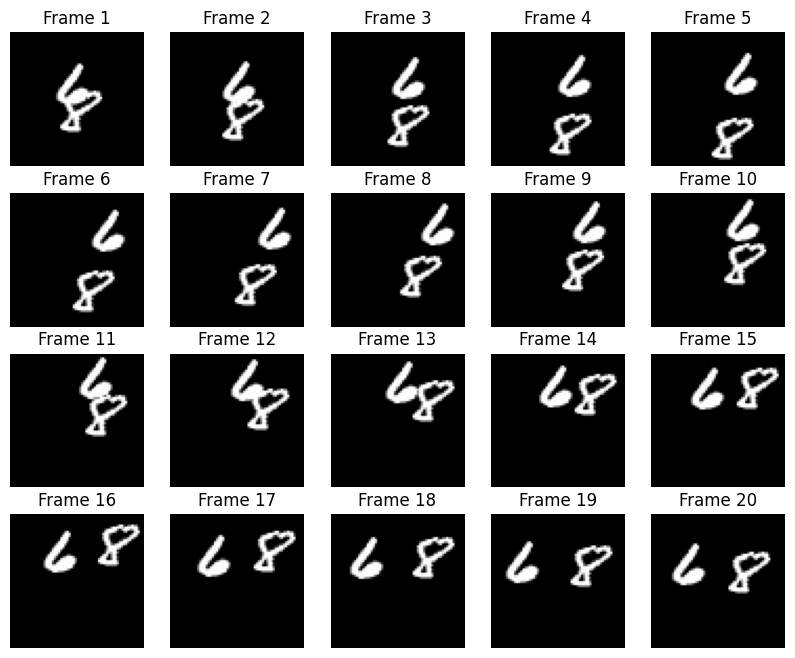

CPU times: user 1.2 s, sys: 139 ms, total: 1.34 s
Wall time: 1.25 s


In [8]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [9]:
from src.plot_images import *

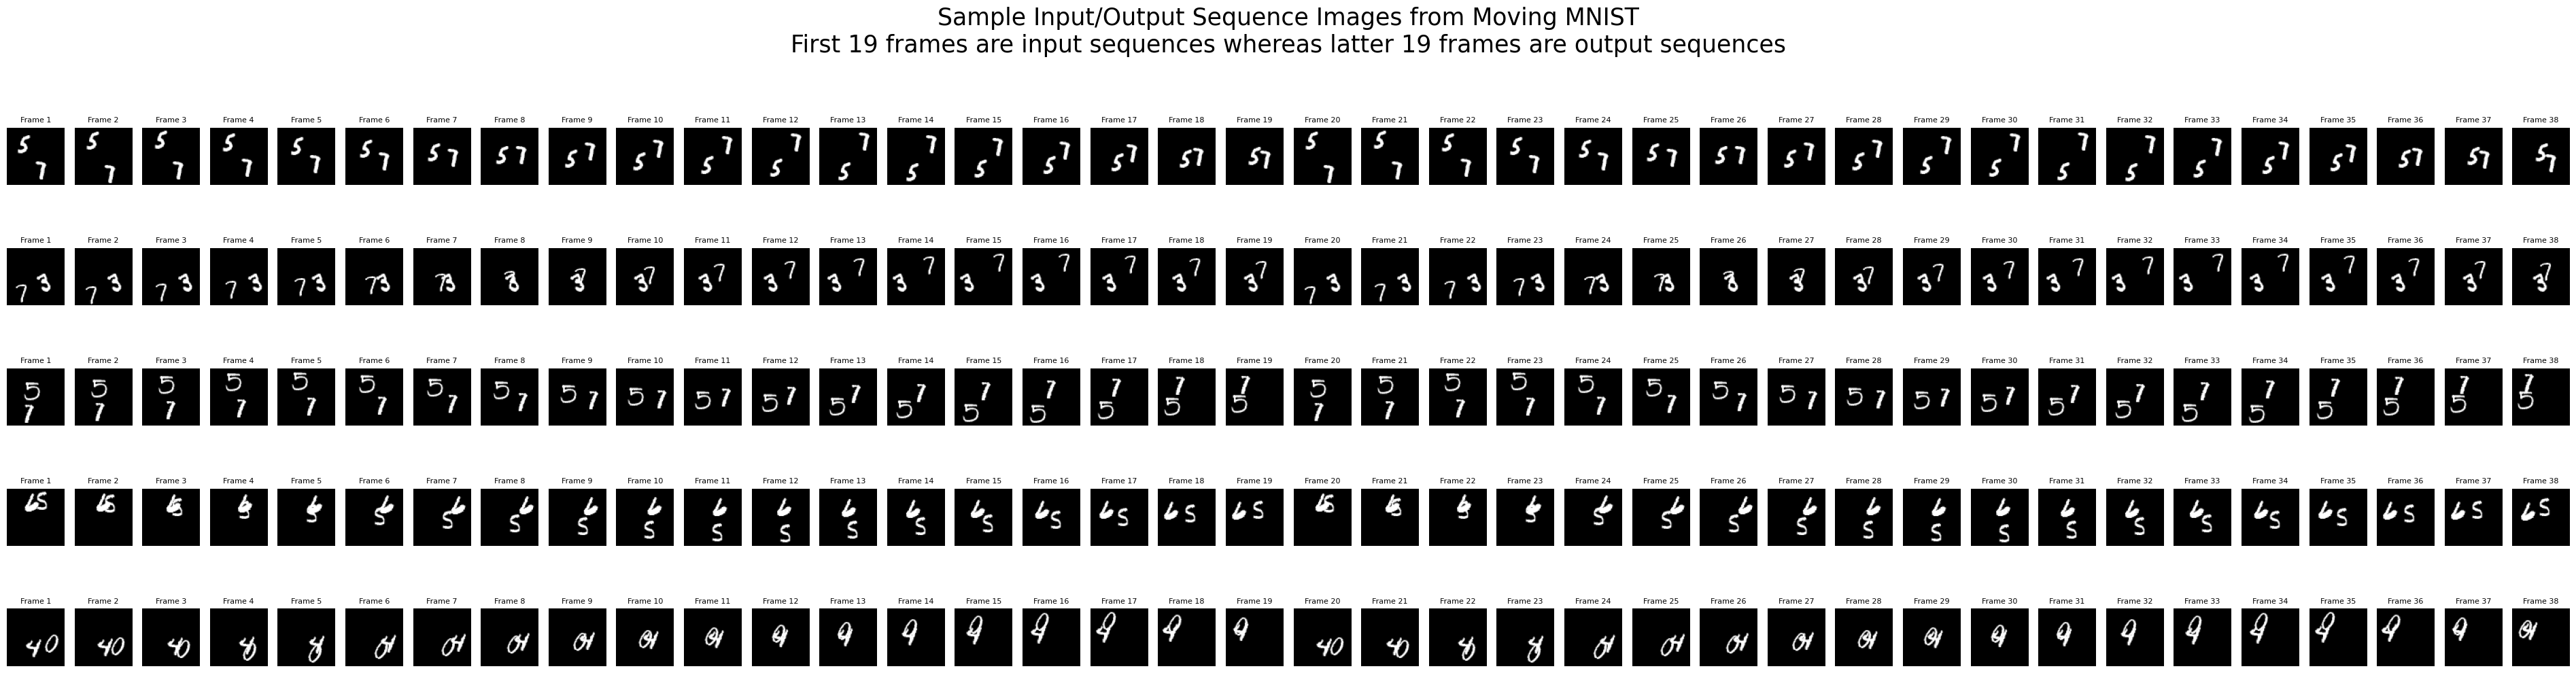

CPU times: user 12.1 s, sys: 215 ms, total: 12.3 s
Wall time: 12.2 s


In [10]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

## Build `VAPAAD` Model

In [11]:
from src.vapaad import *

## Get Ready for Training

In [12]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (9000, 19, 64, 64, 1), (9000, 19, 64, 64, 1)
Validation Dataset Shapes: (1000, 19, 64, 64, 1), (1000, 19, 64, 64, 1)


### Convert to `16bit` data

In [13]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [14]:
# Check gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[1773 4449 6787 1702 2292 3716]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


## Define model: `VAPAAD`

In [16]:
# Initializing a new VAPAAD model
vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

In [17]:
# Readme
vapaad_model.__read_me__()


            ## Instructions

            Assume you have data as the follows:

            ```py
            # Inspect the dataset.
            print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
            print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

            # output
            # Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
            # Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
            ```

            To run the model, execute the following:
            ```py
            # Initializing a new VAPAAD model
            vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

            # Assuming x_train and y_train are already defined and loaded
            num_samples = 64
            indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
            print(indices[0:6])
            x_train_sub = x_train[indices]
            y_train_sub = y_t

### Train

In [18]:
%%time

# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

# Example usage:
BATCH_SIZE = 3
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
else:
    vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

[7079 1997 6027 8665 3419 5921]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


> running: current sample 1, gen_loss=0.6935176849365234, inst_loss=1.3854382038116455, time=19.20546579360962 sec
> running: current sample 4, gen_loss=0.6936429142951965, inst_loss=1.3831254243850708, time=20.914007425308228 sec
> running: current sample 7, gen_loss=0.6953943371772766, inst_loss=1.3849104642868042, time=22.40461254119873 sec
> running: current sample 10, gen_loss=0.6961586475372314, inst_loss=1.3813257217407227, time=23.88858413696289 sec
> running: current sample 13, gen_loss=0.6983881592750549, inst_loss=1.3778396844863892, time=25.37750506401062 sec
> running: current sample 16, gen_loss=0.6980875134468079, inst_loss=1.3751955032348633, time=27.573569297790527 sec
> running: current sample 19, gen_loss=0.6990006566047668, inst_loss=1.3670421838760376, time=29.655956506729126 sec
> running: current sample 22, gen_loss=0.7022285461425781, inst_loss=1.3557920455932617, time=31.49233388900757 sec
> running: current sample 25, gen_loss=0.7049811482429504, inst_loss=1.3

### Extract generator

In [19]:
# Assuming you have a method to get the trained generator
trained_generator = vapaad_model.gen_main

### Prediction Using Generator

In [ ]:
%%time

# prediction on validation set
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        y_val_pred = trained_generator.predict(x_val)
else:
    y_val_pred = trained_generator.predict(x_val)

print("Shape of true y_val:", y_val.shape)
print("Shape of predicted y_val:", y_val_pred.shape)

## Visualization

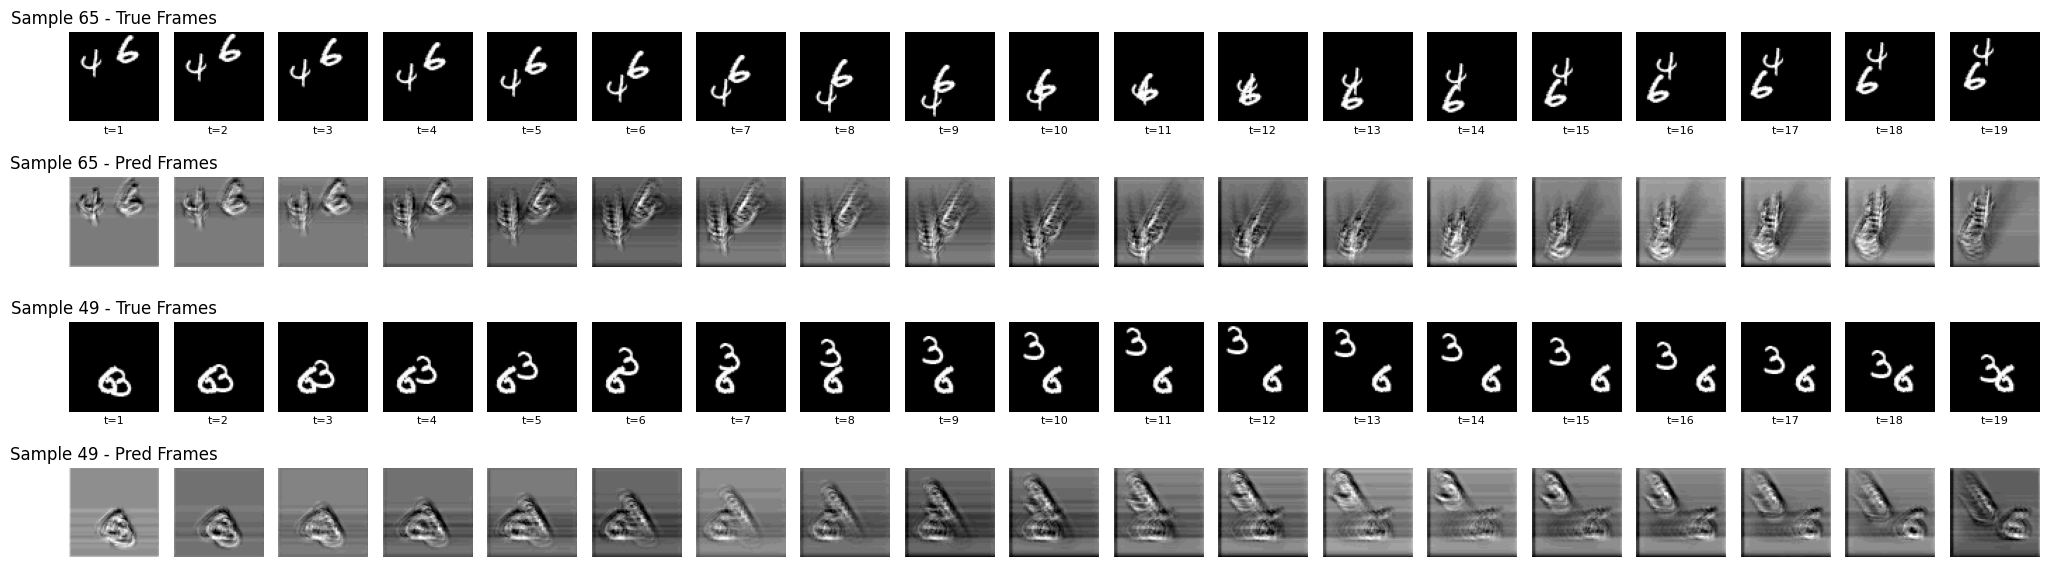

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

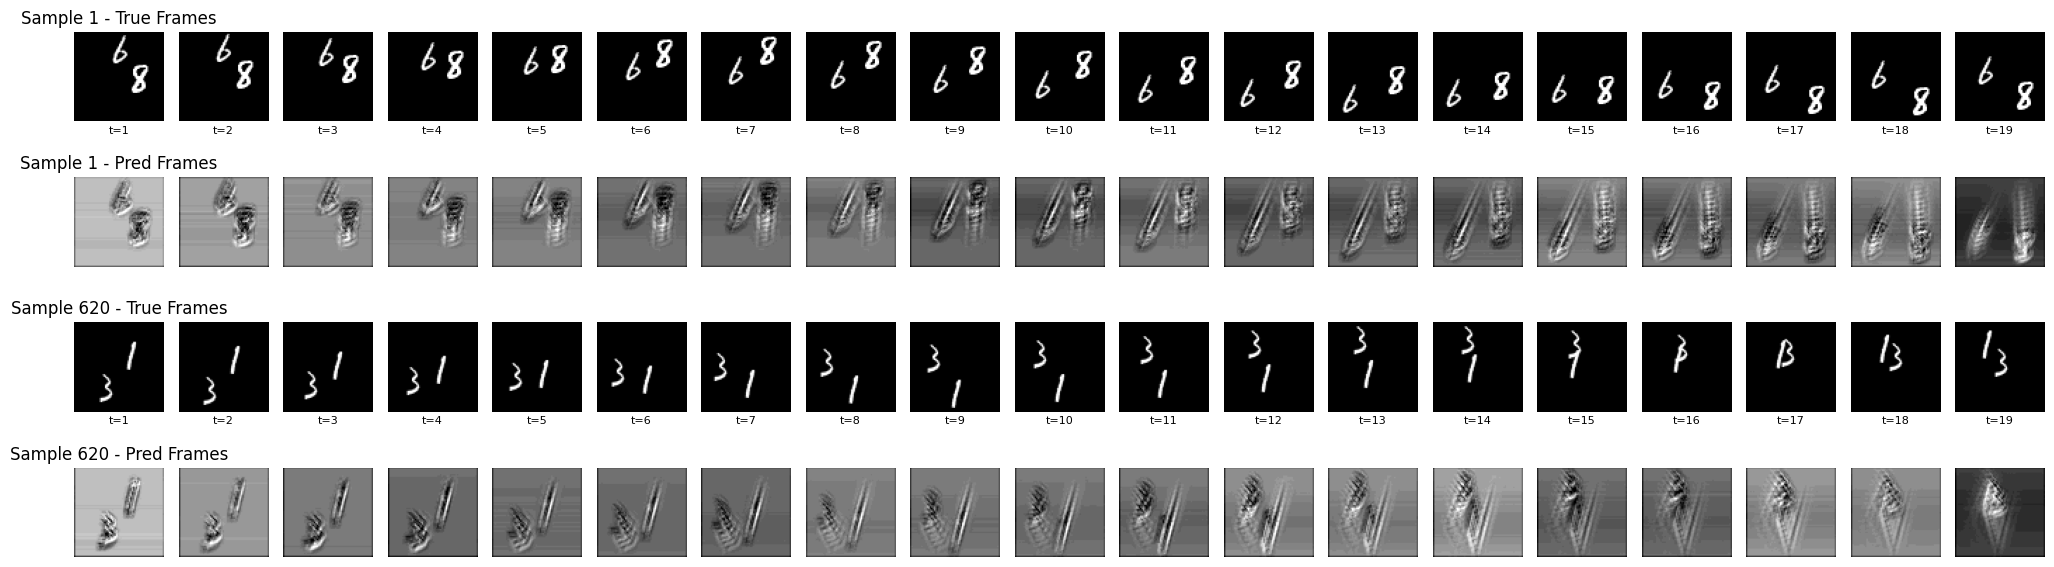

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

## Create `.gif`

In [ ]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad_stop_grad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
        new_prediction = rescale_and_discretize(new_prediction)
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 0s 63ms/step
Truth	Prediction
